<font color='tomato'><font color="#CC3D3D"><p>
# Baseline for Competition #2

- 백화점 구매이력에서 파생된 Feature를 사용하여 `고객의 성별(여자:0, 남자:1)을 예측`하는 문제
- Feature Engineering 역량만을 평가하기 위한 Competition으로 사전 지정된 모델(`CatBoost`)만을 사용하여 예측 
  - 모델링(X), 튜닝(X), 앙상블(X)
  - CatBoost는 여러개의 의사결정나무를 앙상블하는 알고리즘의 일종

### Import modules

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import pickle
import warnings; warnings.filterwarnings("ignore")

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
# 이번 컴피티션에서는 CatBoost 모델만 사용하여 진행!!!
from catboost import CatBoostClassifier

## Step 1: Data Preprocessing

##### Read data

In [3]:
X_train = pd.read_csv('X_train.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv').gender
X_test = pd.read_csv('X_test.csv', encoding='cp949')

# submission을 만들 때 사용하기 위해 ID 저정
id_test = X_test.id

In [3]:
X = X_train.columns 

##### Explore data

In [4]:
# 결측값 존재여부와 범주형 feature 확인
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 67 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  3500 non-null   int64  
 1   총구매액                3500 non-null   int64  
 2   구매건수                3500 non-null   int64  
 3   평균구매액               3500 non-null   int64  
 4   최대구매액               3500 non-null   int64  
 5   구매상품종류1             3500 non-null   int64  
 6   내점일수                3500 non-null   int64  
 7   구매주기                3500 non-null   int64  
 8   봄-구매비율              3500 non-null   float64
 9   여름-구매비율             3500 non-null   float64
 10  가을-구매비율             3500 non-null   float64
 11  겨울-구매비율             3500 non-null   float64
 12  환불금액                1205 non-null   float64
 13  환불건수                1205 non-null   float64
 14  내점당구매액              3500 non-null   float64
 15  내점당구매건수             3500 non-null   float64
 16  주구매상품 

In [5]:
# 환불금액, 환불건수, 화장품구매주기, 주환불상품, 남성포함상품구매건수
# 행사상품구매수, 만족도 떨어지는 제품 총 구입금액

X_train.drop(columns=['id','환불금액', '환불건수','화장품구매주기','주환불상품', '남성포함상품구매건수','행사상품구매수',
                     '만족도 떨어지는 제품 총 구입금액'], axis=1, inplace=True)

X_test.drop(columns=['id','환불금액', '환불건수','화장품구매주기','주환불상품', '남성포함상품구매건수','행사상품구매수',
                     '만족도 떨어지는 제품 총 구입금액'], axis=1, inplace=True)

In [6]:
# 범주형 변수와 수치형 변수를 분리
cat_features = X_train.select_dtypes(include=['object']).columns.to_list()
num_features = list(set(X_train.columns) - set(cat_features))

##### Impute missing values

In [7]:
from sklearn.impute import SimpleImputer 

if len(num_features) > 0:
    imp = SimpleImputer(strategy='mean')
    X_train[num_features] = imp.fit_transform(X_train[num_features])
    X_test[num_features] = imp.transform(X_test[num_features])
if len(cat_features) > 0:  
    imp = SimpleImputer(strategy="most_frequent")
    X_train[cat_features] = imp.fit_transform(X_train[cat_features])
    X_test[cat_features] = imp.transform(X_test[cat_features])

In [8]:
X_train[num_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 52 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   의류_거래율(의류+식품+생활잡화)  3500 non-null   float64
 1   명절식품비용              3500 non-null   float64
 2   월_재방문율              3500 non-null   float64
 3   여름-구매비율             3500 non-null   float64
 4   시즌 마감 방문비율          3500 non-null   float64
 5   베스트셀러구매비율           3500 non-null   float64
 6   단독상품군구매율            3500 non-null   float64
 7   구매 추세 기울기           3500 non-null   float64
 8   다양한 매장 방문           3500 non-null   float64
 9   상반기 구매비율            3500 non-null   float64
 10  식료품구매액비율            3500 non-null   float64
 11  총구매액                3500 non-null   float64
 12  패션_대비_남성상품_거래율      3500 non-null   float64
 13  평균구매액               3500 non-null   float64
 14  구매 추세               3500 non-null   float64
 15  남성용품구매건수            3500 non-null   float64
 16  구매액표준편

##### Transform features (Feature Scaling)

In [9]:
# DNN 모델링에서는 StandardScaler을 주로 사용
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

##### Encode Categorical Variables

In [10]:
df_encoded = pd.get_dummies(pd.concat([X_train, X_test]), columns=cat_features)
X_train = df_encoded[:X_train.shape[0]]
X_test = df_encoded[X_train.shape[0]:]

#### Feature Importance

In [11]:
# 피처 중요도
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


model = LogisticRegression()
model.fit(X_train, y_train)


coefficients = model.coef_[0]

feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
feature_importance.head(30)

,Feature,Importance
115,주구매지점_전주점,1.154363
78,주구매상품_액세서리,0.956980
88,주구매상품_침구/수예,0.916825
53,주구매상품_가구,0.836387
99,주구매지점_대구점,0.808284
123,고객등급_vip고객,0.760808
76,주구매상품_아동,0.729170
95,주구매지점_강남점,0.656520
146,라이프 스타일(건수)_여성의류,0.653833
105,주구매지점_부평점,0.625919


In [12]:
X_train['g1'] = X_train.groupby('주구매지점_전주점')['주구매상품_액세서리'].transform('count')      
X_test['g1'] = X_test.groupby('주구매지점_전주점')['주구매상품_액세서리'].transform('count') 

X_train['g2'] = X_train.groupby('주구매지점_전주점')['주구매상품_액세서리'].transform('sum')      
X_test['g2'] = X_test.groupby('주구매지점_전주점')['주구매상품_액세서리'].transform('sum') 

X_train['g3'] = X_train.groupby('주구매지점_전주점')['주구매상품_액세서리'].transform('mean')      
X_test['g3'] = X_test.groupby('주구매지점_전주점')['주구매상품_액세서리'].transform('mean') 



In [13]:
X_train['여성용품구매건수_라이프스타일'] = X_train['여성용품구매건수']+X_train['라이프 스타일(건수)_여성의류']
X_test['여성용품구매건수_라이프스타일'] = X_test['여성용품구매건수']+X_test['라이프 스타일(건수)_여성의류']

X_train['주구매지점_전주점_대구점'] = X_train['주구매지점_전주점']+X_train['주구매지점_대구점']
X_test['주구매지점_전주점_대구점'] = X_test['주구매지점_전주점']+X_test['주구매지점_대구점']

X_train['주구매상품/주구매건수_아동용품'] = X_train['주구매상품_아동']+X_train['아동용품 구매건수']
X_test['주구매상품/주구매건수_아동용품'] = X_test['주구매상품_아동']+X_test['아동용품 구매건수']

X_train['주구매지점_전주점_액세서리'] = X_train['주구매지점_전주점']+X_train['주구매상품_액세서리']
X_test['주구매지점_전주점_액세서리'] = X_test['주구매지점_전주점']+X_test['주구매상품_액세서리']

X_train['주구매상품_액세서리/침구'] = X_train['주구매상품_액세서리']+X_train['주구매상품_침구/수예']
X_test['주구매상품_액세서리/침구'] = X_test['주구매상품_액세서리']+X_test['주구매상품_침구/수예']

X_train['new_3'] = X_train['주구매지점_대구점']+X_train['고객등급_vip고객']
X_test['new_3'] = X_test['주구매지점_대구점']+X_test['고객등급_vip고객']

X_train['new_4'] = X_train['주구매상품_아동']+X_train['라이프 스타일(건수)_여성의류']
X_test['new_4'] = X_test['주구매상품_아동']+X_test['라이프 스타일(건수)_여성의류']

X_train['new_5'] = X_train['주구매지점_강남점']+X_train['주구매지점_부평점']
X_test['new_5'] = X_test['주구매지점_강남점']+X_test['주구매지점_부평점']

X_train['new_2'] = X_train['주구매상품_침구/수예']+X_train['주구매상품_가구']
X_test['new_2'] = X_test['주구매상품_침구/수예']+X_test['주구매상품_가구']

X_train['new_6'] = X_train['주구매상품_보석']+X_train['주구매상품_액세서리']
X_test['new_6'] = X_test['주구매상품_보석']+X_test['주구매상품_액세서리']



##### Select Features

  0%|          | 0/95 [00:00<?, ?it/s]

(64, 0.7400849406381648)


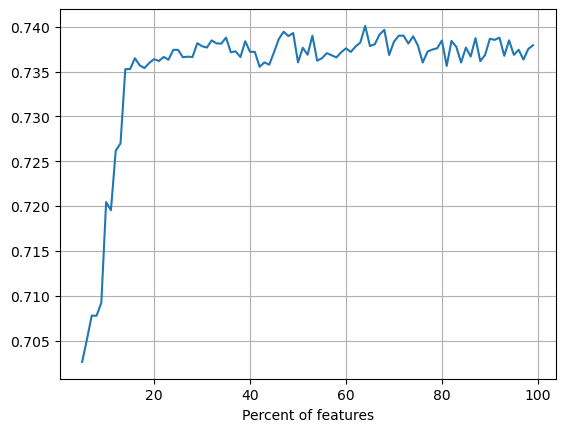

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import cross_val_score
from tqdm import tqdm, tqdm_notebook

# 사용할 모델 설정 
model = LogisticRegression(random_state=0)

# 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법 
cv_scores = []
for p in tqdm_notebook(range(5,100,1)):
    X_new = SelectPercentile(percentile=p).fit_transform(X_train, y_train)    
    cv_score = cross_val_score(model, X_new, y_train, scoring='roc_auc', cv=10).mean()
    cv_scores.append((p,cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

In [15]:
fs = SelectPercentile(percentile=best_score[0]).fit(X_train, y_train)
X_train = fs.transform(X_train)
X_test = fs.transform(X_test)

print(X_train.shape)

(3500, 111)


<font color='tomato'><font color="#CC3D3D"><p>
### Step 2: Modeling
아래 코드는 절대 수정하지 말것!!! 수정하여 submission 제출시 무조건 0점 처리함!!!

##### Build models

In [16]:
model = CatBoostClassifier(random_state=0, silent=True)
model.fit(X_train, y_train)

##### Evaluate models

In [17]:
# 모델 성능 내부 검증
scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=5)
scores.mean(), scores.std()

(0.7399577491112768, 0.019340967158699585)

mean - (0.7407999474020514, 0.02058546640403137)  
median - (0.7422868681441426, 0.021235942582327885)  
피처3, cv=10 - (0.7436855003061186, 0.01944780364250979)

수인+민지 : (0.7443580498572924, 0.019019630819702964)

##### Make submissions & Save features

In [18]:
# 만들어진 csv화일 => 캐글에 submission
t = pd.Timestamp.now()
fname = f"submission_{t.month:02}{t.day:02}{t.hour:02}{t.minute:02}.csv"
pd.DataFrame({'id': id_test, 'gender': model.predict_proba(X_test)[:,1]}).to_csv(fname, index=False)
print(f"'{fname}' is ready to submit.")

# pickle 형식으로 저장 => 컴피티션 종료 후 가장 성능이 높은 화일을 담당교수 이메일로 제출
fname = f"features_{t.month:02}{t.day:02}{t.hour:02}{t.minute:02}.pkl"
with open(fname, 'wb') as f:
    pickle.dump((X_train, X_test, model), f)

'submission_05192353.csv' is ready to submit.


<font color="#CC3D3D"><p>
# End